# import modules

In [2]:
import keras
from keras.utils import plot_model, to_categorical
from keras import Model, Input, regularizers
from keras.layers import Reshape, Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, BatchNormalization, MaxPool1D
from keras.models import Model


from attention_utils import get_activations
# from keras.layers import merge
from keras.layers.core import *
from keras.layers import LSTM
from keras.models import *

import pandas as pd
import numpy as np
from keras.wrappers import scikit_learn

# Load Features

In [3]:
# X_features=np.load('X_gabor.npy')
# y=np.load('y_final.npy')
X_features=np.load('data.npy', allow_pickle=True)
y=np.load('label.npy', allow_pickle=True)

In [4]:
X_features.shape

(61228, 20, 7)

In [5]:
y.shape

(61228, 24)

In [6]:
y[0]

array(['5', '5', '3', '5', '4', '1', '5', '6', '9', '9', '0', '6', '8',
       '7', '9', '4', '0', '4', '6', '0', '0', '0', '0', '1'], dtype='<U1')

In [7]:
# Select one random character from the unique characters from each array of y (to be used as labels)
y_4 = np.array([np.random.choice(np.unique(y[i]), 1) for i in range(len(y))])
y_4.shape

(61228, 1)

In [ ]:
X_features[0]

In [8]:
y_4[0]

array(['6'], dtype='<U1')

In [42]:
alphabet_set={'0': 0,'a': 1,'e': 2,'g': 3,'i': 4,'n': 5,'o': 6,'r': 7,'u': 8,'v': 9}

In [43]:
alphabet_set={value:key for key,value in alphabet_set.items()}

## One-hot Encoding

In [9]:
y_4 = np.expand_dims(y_4, axis=1)

In [10]:
y_new = to_categorical(y_4,num_classes=10)

In [11]:
y_new.shape

(61228, 1, 10)

In [12]:
y_new[0]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

## split train and test

In [13]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y_new,test_size=0.2) #,random_state=2019

In [14]:
X_train.shape,X_test.shape

((48982, 20, 7), (12246, 20, 7))

In [15]:
y_train.shape,y_test.shape

((48982, 1, 10), (12246, 1, 10))

# Models


In [16]:
NUM_CLASSES=10
BATCH_SIZE=128
EPOCHS=10
MODEL_SAVE_PATH='model/final_gabor_cnn.h5'

In [20]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax', name='attention')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model():
    inputs = Input(shape=(20, 7)) # shape has been changed from (35,7) for the new data
    x=BatchNormalization()(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
    x = MaxPool1D()(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = MaxPool1D(pool_size=10,strides=2)(attention_mul)

    # FOLLOWING LINES OF CODE ARE MODIFIED TO USE WITH THE NEW DATA
    
    # Flatten the attention_mul output
    # attention_mul = Flatten()(attention_mul)
    # Use a Dense layer with 10 units
    output = Dense(10, activation='sigmoid')(attention_mul)
    # Reshape the output to (None, 4, 10)
    # output = Reshape((4, 10))(output)

    model = Model(inputs=[inputs], outputs=output)
    return model

In [21]:
model = attention_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 7)]      0           []                               
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 20, 7)       28          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 conv1d_1 (Conv1D)              (None, 20, 32)       256         ['batch_normalization_1[0][0]']  
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 10, 32)      0           ['conv1d_1[0][0]']         

In [ ]:
# K.clear_session()
# inputs=Input(shape=(35,7))
# x=Bidirectional(LSTM(32,return_sequences=True,dropout=0.25))(inputs)
# #x=Bidirectional(LSTM(50,dropout=0.25))(x)
# x=Dense(NUM_CLASSES,activation='softmax')(x)
# model=Model(inputs=inputs,outputs=x)
# model.summary()

In [22]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# plot_model(model,'model_final.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)

Epoch 1/10
383/383 [==============================] - ETA: 0s - loss: 2.3000 - accuracy: 0.1120
Epoch 1: val_accuracy improved from -inf to 0.11114, saving model to model\final_gabor_cnn.h5
383/383 [==============================] - 30s 49ms/step - loss: 2.3000 - accuracy: 0.1120 - val_loss: 2.2997 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 2/10
382/383 [============================>.] - ETA: 0s - loss: 2.2995 - accuracy: 0.1130
Epoch 2: val_accuracy did not improve from 0.11114
383/383 [==============================] - 20s 53ms/step - loss: 2.2995 - accuracy: 0.1130 - val_loss: 2.2994 - val_accuracy: 0.1101 - lr: 0.0010
Epoch 3/10
382/383 [============================>.] - ETA: 0s - loss: 2.2993 - accuracy: 0.1136
Epoch 3: val_accuracy did not improve from 0.11114
383/383 [==============================] - 20s 53ms/step - loss: 2.2993 - accuracy: 0.1136 - val_loss: 2.2995 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 4/10
382/383 [============================>.] - ETA: 0s - loss: 2.2994 -

## plot_curve

In [ ]:
# from help import plot_curve,plot_curve_with_smooth

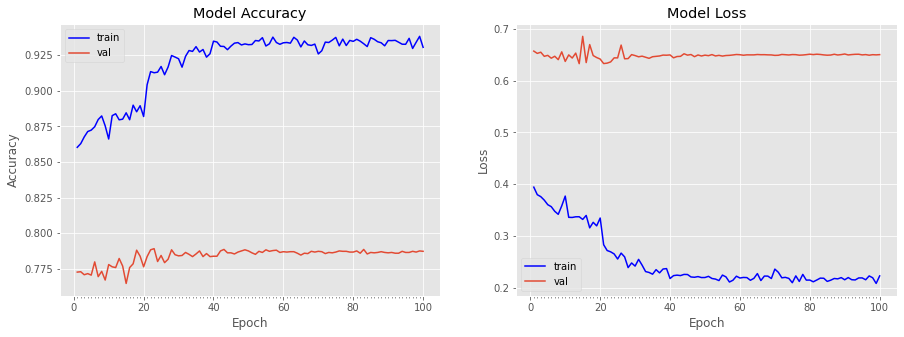

In [ ]:
# plot_curve(history)

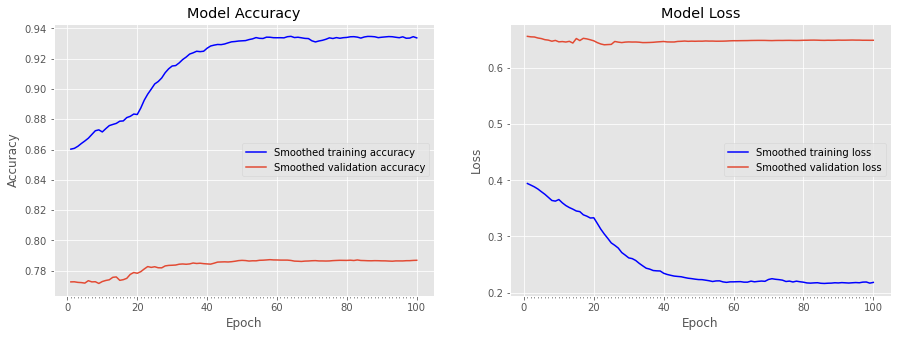

In [ ]:
# plot_curve_with_smooth(history)

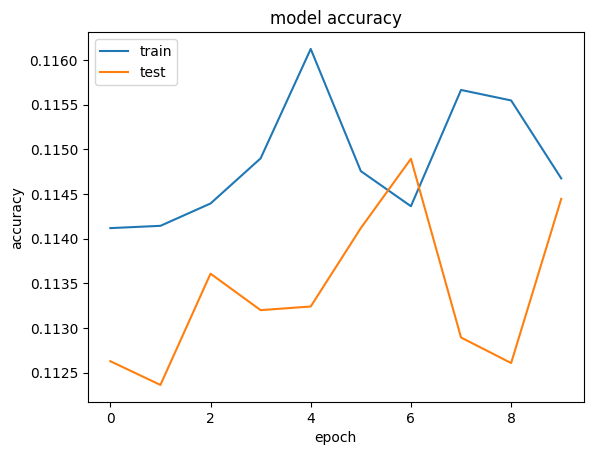

In [30]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## confusion_metrix

In [31]:
model.load_weights('model/final_gabor_cnn.h5')

383/383 [==============================] - 6s 8ms/step


<Axes: >

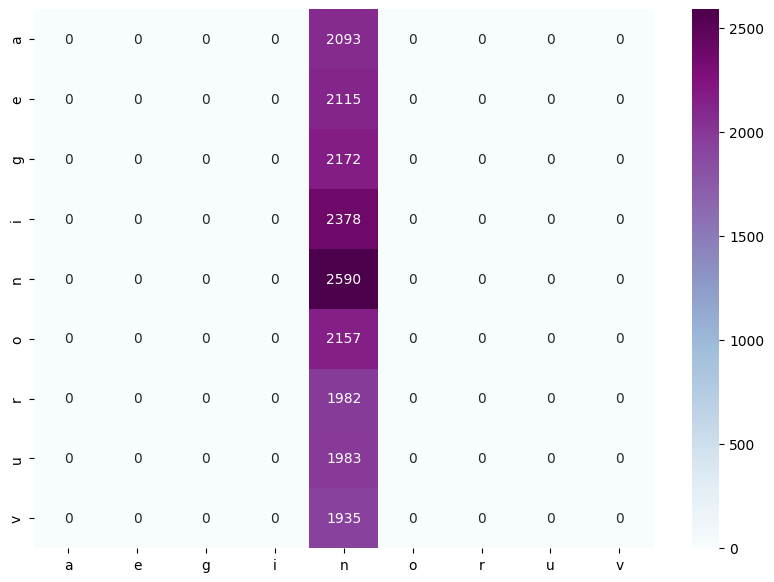

In [34]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# %matplotlib inline
# y_pred=model.predict(X_test)
# y_pred=np.argmax(y_pred,axis=-1).ravel()
# y_true=np.argmax(y_test,axis=-1).ravel()
# con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
# def plot_confusion_matrix(confusion_mat):
#     plt.figure(figsize=(12,8))
#     plt.imshow(confusion_mat)
#     plt.title('Confusion Matrix')
#     plt.colorbar()
#     labels = list(range(0,10))
#     tick_marks = np.arange(len(labels))
#     plt.xticks(tick_marks, labels)
#     plt.yticks(tick_marks, labels)
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.grid(False)
#     plt.show() 
# plot_confusion_matrix(con_matrix)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
target_names=[alphabet_set[i] for i in range(1,10)]
# print(con_matrix)
con_matrix=con_matrix[1:,1:]
# print(con_matrix)
import seaborn as sn

df_cm = pd.DataFrame(con_matrix,
                     index = [i for i in list(target_names)],
                     columns = [i for i in list(target_names)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.20g',cmap="BuPu")

## classfication_report

In [32]:
from sklearn.metrics import classification_report


In [35]:
target_names=[alphabet_set[i] for i in range(10)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(10)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.1121    0.5500    0.1863      5524
           a     0.0000    0.0000    0.0000      4670
           e     0.0000    0.0000    0.0000      4887
           g     0.0000    0.0000    0.0000      4816
           i     0.0000    0.0000    0.0000      5311
           n     0.1183    0.4611    0.1883      5617
           o     0.0000    0.0000    0.0000      4719
           r     0.0000    0.0000    0.0000      4539
           u     0.0000    0.0000    0.0000      4521
           v     0.0000    0.0000    0.0000      4380

    accuracy                         0.1149     48984
   macro avg     0.0230    0.1011    0.0375     48984
weighted avg     0.0262    0.1149    0.0426     48984



# predict test

In [ ]:
temp = np.load('./gabor/person1_time1_group1_da_4.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:a


In [ ]:
temp = np.load('./gabor/person6_time1_group1_ge_4.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:e


In [ ]:
temp = np.load('./gabor/person10_time1_group2_zhong_1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:in


In [ ]:
target_names=[alphabet_set[i] for i in range(10)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(10)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.8932    0.9272    0.9099      1922
           a     0.6667    0.6741    0.6704       359
           e     0.4779    0.4252    0.4500       127
           g     0.5441    0.4744    0.5068       156
           i     0.7068    0.6862    0.6964       376
           n     0.5927    0.5821    0.5873       335
           o     0.7241    0.6604    0.6908       159
           r     0.7500    0.6316    0.6857        19
           u     0.7980    0.8225    0.8101       293
           v     0.0000    0.0000    0.0000        18

    accuracy                         0.7872      3764
   macro avg     0.6154    0.5884    0.6007      3764
weighted avg     0.7782    0.7872    0.7823      3764

